<a href="https://colab.research.google.com/github/qader48/energy/blob/main/Energy_Cons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error


In [ ]:
df = pd.read_csv('/content/final_dataset.csv')
df = df.fillna(method = 'ffill')
df['time'] = pd.to_datetime(df['time'])
df.head(2)

<ipython-input-3-2932dc0eff1e>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method = 'ffill')


,time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Precipitation,CloudCover,Temperature,Snowfall,Wind
0,2007-01-01 00:00:00,2.537017,0.092217,241.228917,10.486667,0.0,0.291667,0.0,1.329846e-07,0.999695,286.43298,0.0,9.663516
1,2007-01-01 02:00:00,2.562000,0.098383,243.232917,10.470000,0.0,0.300000,0.0,2.353721e-07,0.556274,285.98602,0.0,8.988889


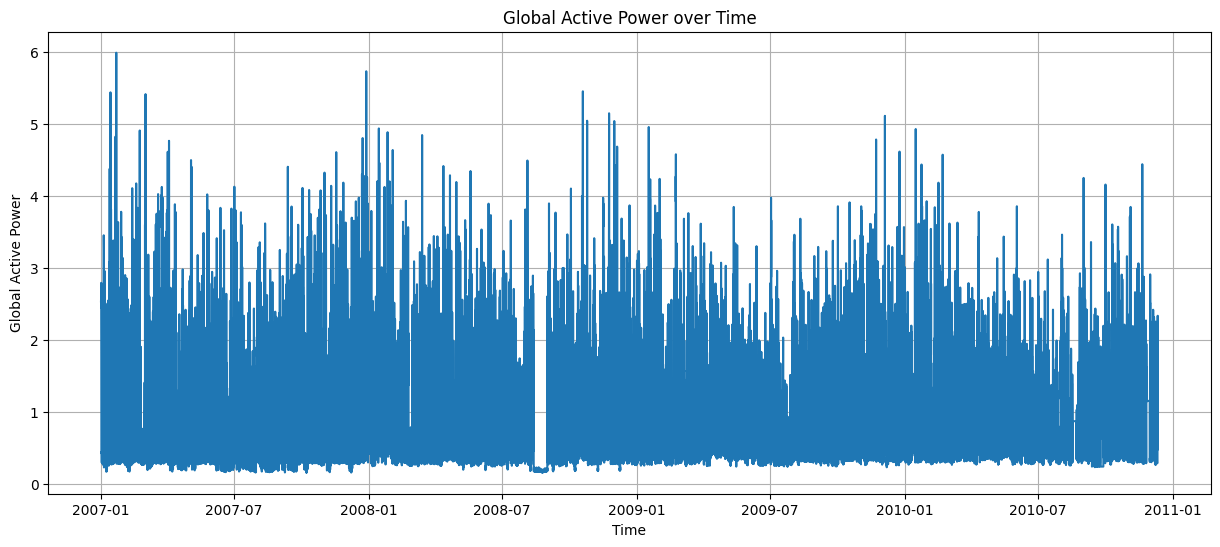

In [ ]:

# Assuming 'df' is your DataFrame containing the data
plt.figure(figsize=(15, 6))  # Adjust figure size as needed
plt.plot(df['time'], df['Global_active_power'])
plt.title('Global Active Power over Time')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.grid(True)  # Add a grid for better readability
plt.show()

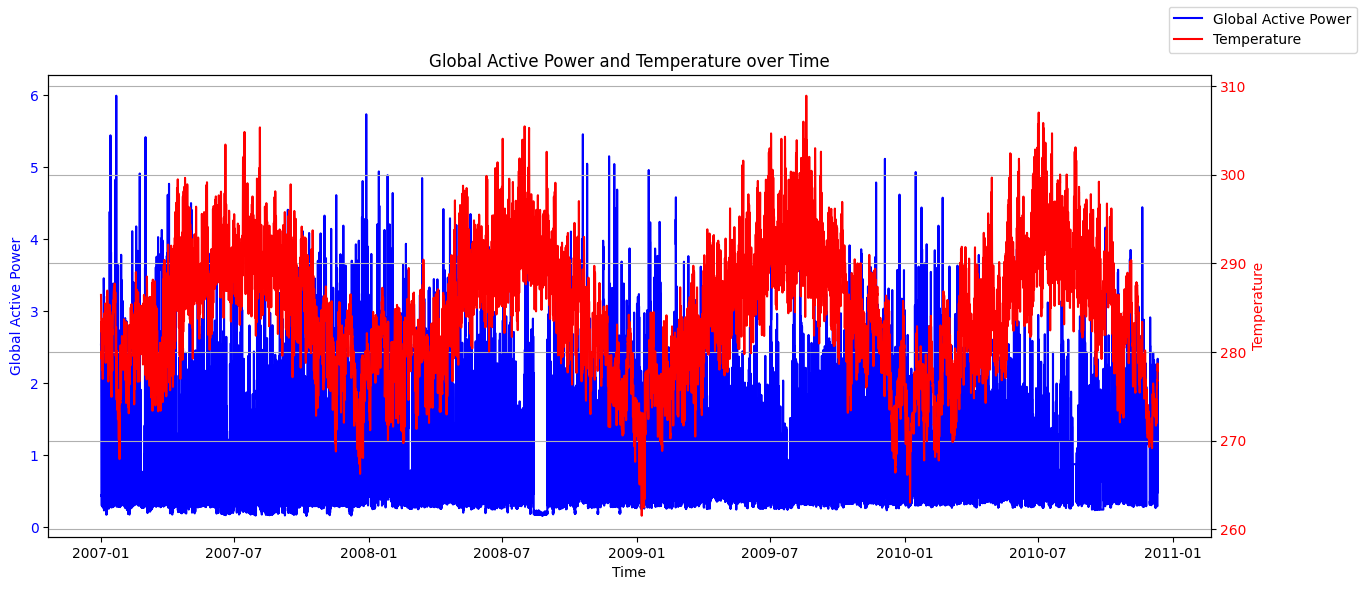

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot Global_active_power on the primary y-axis
ax1.plot(df['time'], df['Global_active_power'], color='blue', label='Global Active Power')
ax1.set_xlabel('Time')
ax1.set_ylabel('Global Active Power', color='blue')
ax1.tick_params('y', labelcolor='blue')

# Create a secondary y-axis for temperature
ax2 = ax1.twinx()
ax2.plot(df['time'], df['Temperature'], color='red', label='Temperature')
ax2.set_ylabel('Temperature', color='red')
ax2.tick_params('y', labelcolor='red')

# Add title, legend, and grid
plt.title('Global Active Power and Temperature over Time')
fig.legend(loc="upper right")  # Adjust legend location as needed
plt.grid(True)

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [ ]:
data = pd.read_csv('/content/final_dataset.csv')
data = data.fillna(method = 'ffill')
data['time'] = pd.to_datetime(df['time'])
data.head(2)

<ipython-input-20-962a35c03e82>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method = 'ffill')


,time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Precipitation,CloudCover,Temperature,Snowfall,Wind
0,NaT,2.537017,0.092217,241.228917,10.486667,0.0,0.291667,0.0,1.329846e-07,0.999695,286.43298,0.0,9.663516
1,NaT,2.562000,0.098383,243.232917,10.470000,0.0,0.300000,0.0,2.353721e-07,0.556274,285.98602,0.0,8.988889


In [ ]:
data['time'] = pd.to_datetime(data['time'])
data['hour'] = data['time'].dt.hour
data['day_of_week'] = data['time'].dt.dayofweek
data['quarter'] = data['time'].dt.quarter
data['month'] = data['time'].dt.month
data['year'] = data['time'].dt.year
data['day_of_year'] = data['time'].dt.dayofyear

In [ ]:
features = ['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year']
target_columns = ['Global_active_power', 'Global_reactive_power', 'Temperature', 'Global_intensity']

X = data[features]
y = data[target_columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
xgboost_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 1000,  # Increased to allow early stopping
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'device': 'cuda',
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10
}

models = {}

for target in target_columns:
    model = xgb.XGBRegressor(**xgboost_params)  # Use the provided parameters
    # Assuming 'time' is not a feature, remove it from X_train and X_test
    X_train_selected = X_train[[col for col in X_train.columns if col != 'time']]
    X_test_selected = X_test[[col for col in X_test.columns if col != 'time']]
    model.fit(X_train_selected, y_train[target],
              eval_set=[(X_test_selected, y_test[target])],
              verbose=False)  # Set verbose=False to suppress output
    models[target] = model

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:24:36] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:24:36] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:24:37] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:24:37] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:24:38] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnin

In [ ]:
predictions = {}
for target in target_columns:
    predictions[target] = models[target].predict(X_test)

In [ ]:
for target in target_columns:
    mse = mean_squared_error(y_test[target], predictions[target])
    print(f'Mean Squared Error for {target}: {mse}')


Mean Squared Error for Global_active_power: 0.38018387635242445
Mean Squared Error for Global_reactive_power: 0.0023133285911628907
Mean Squared Error for Temperature: 6.610334454568344
Mean Squared Error for Global_intensity: 6.650675455511979


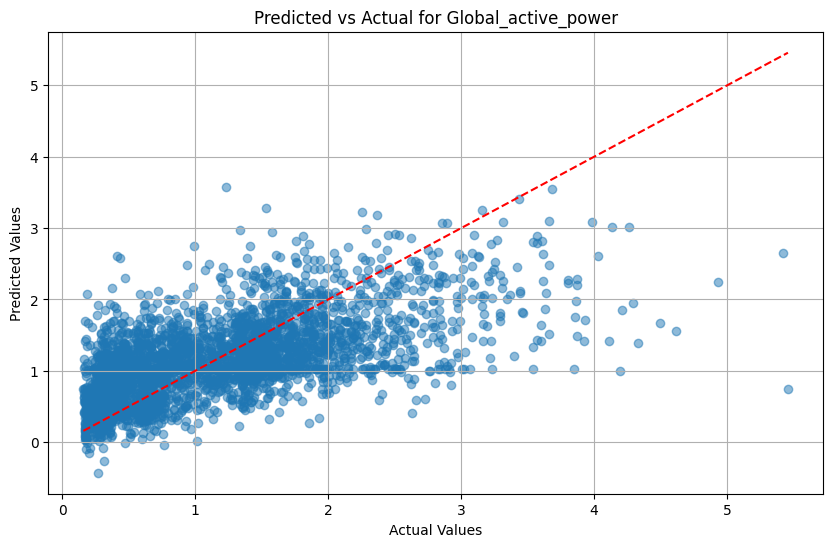

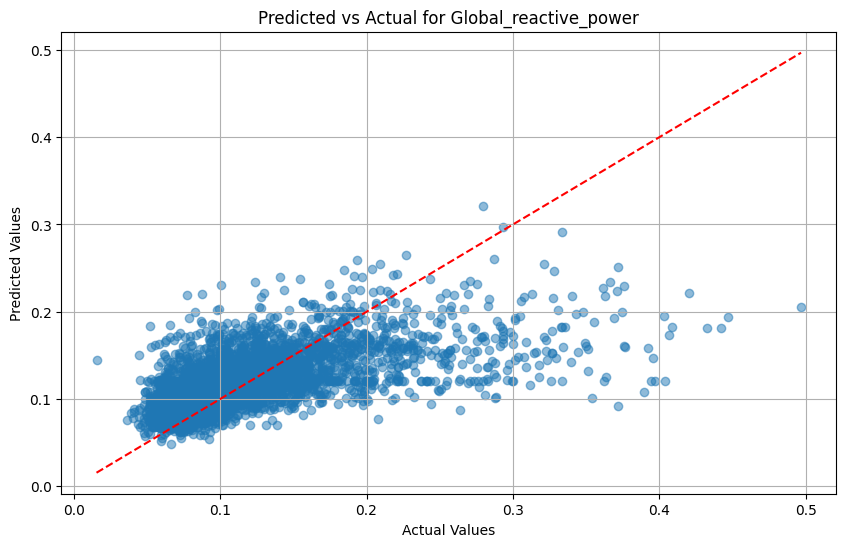

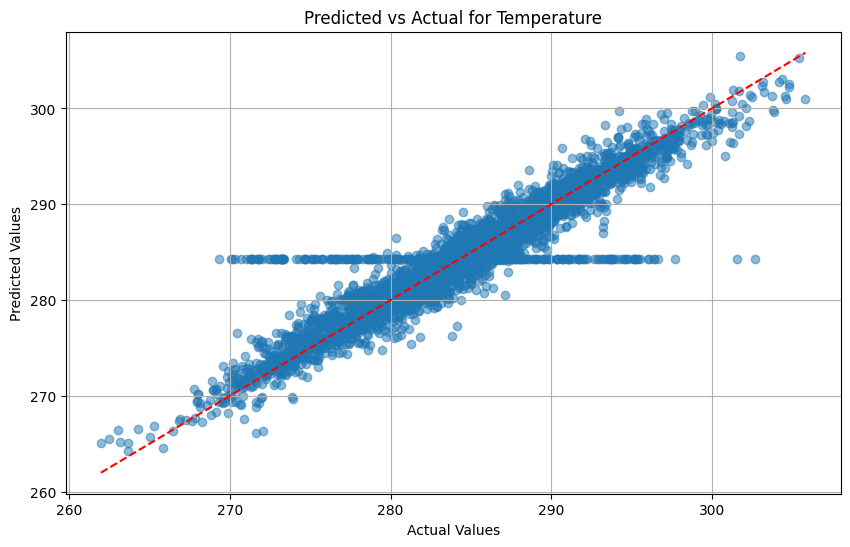

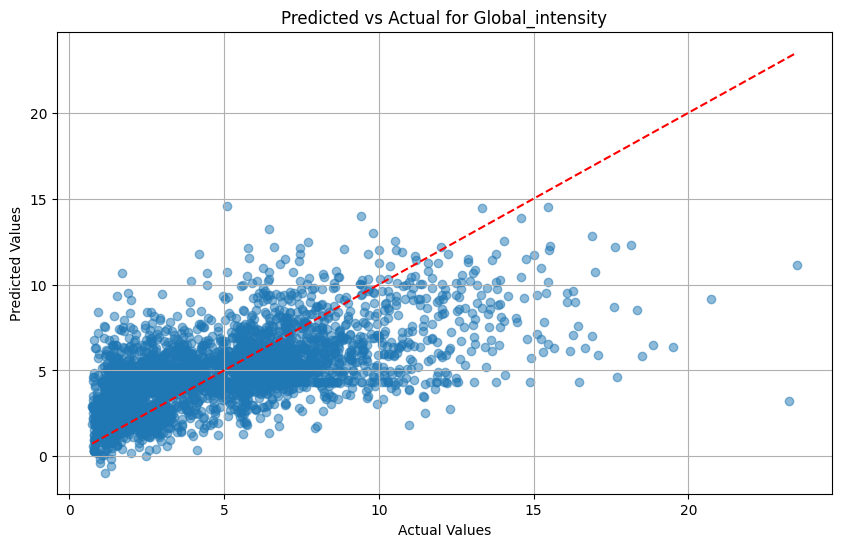

In [ ]:
import matplotlib.pyplot as plt

# Plot predicted vs actual values for each target variable
for target in target_columns:
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.scatter(y_test[target], predictions[target], alpha=0.5)  # Scatter plot
    plt.plot([y_test[target].min(), y_test[target].max()], [y_test[target].min(), y_test[target].max()], 'r--')  # Diagonal line
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs Actual for {target}')
    plt.grid(True)
    plt.show()

In [ ]:

# Create a date range for the next year
future_dates = pd.date_range(start='2010-12-12', end='2011-12-12', freq='H')

# Create a DataFrame for future data
future_data = pd.DataFrame({'time': future_dates})

# Extract features from future dates
future_data['hour'] = future_data['time'].dt.hour
future_data['day_of_week'] = future_data['time'].dt.dayofweek
future_data['quarter'] = future_data['time'].dt.quarter
future_data['month'] = future_data['time'].dt.month
future_data['year'] = future_data['time'].dt.year
future_data['day_of_year'] = future_data['time'].dt.dayofyear

# Select the features for prediction
X_future = future_data[features]

<ipython-input-38-15b3265936a4>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start='2010-12-12', end='2011-12-12', freq='H')


In [ ]:
future_predictions = {}
for target in target_columns:
    future_predictions[target] = models[target].predict(X_future)

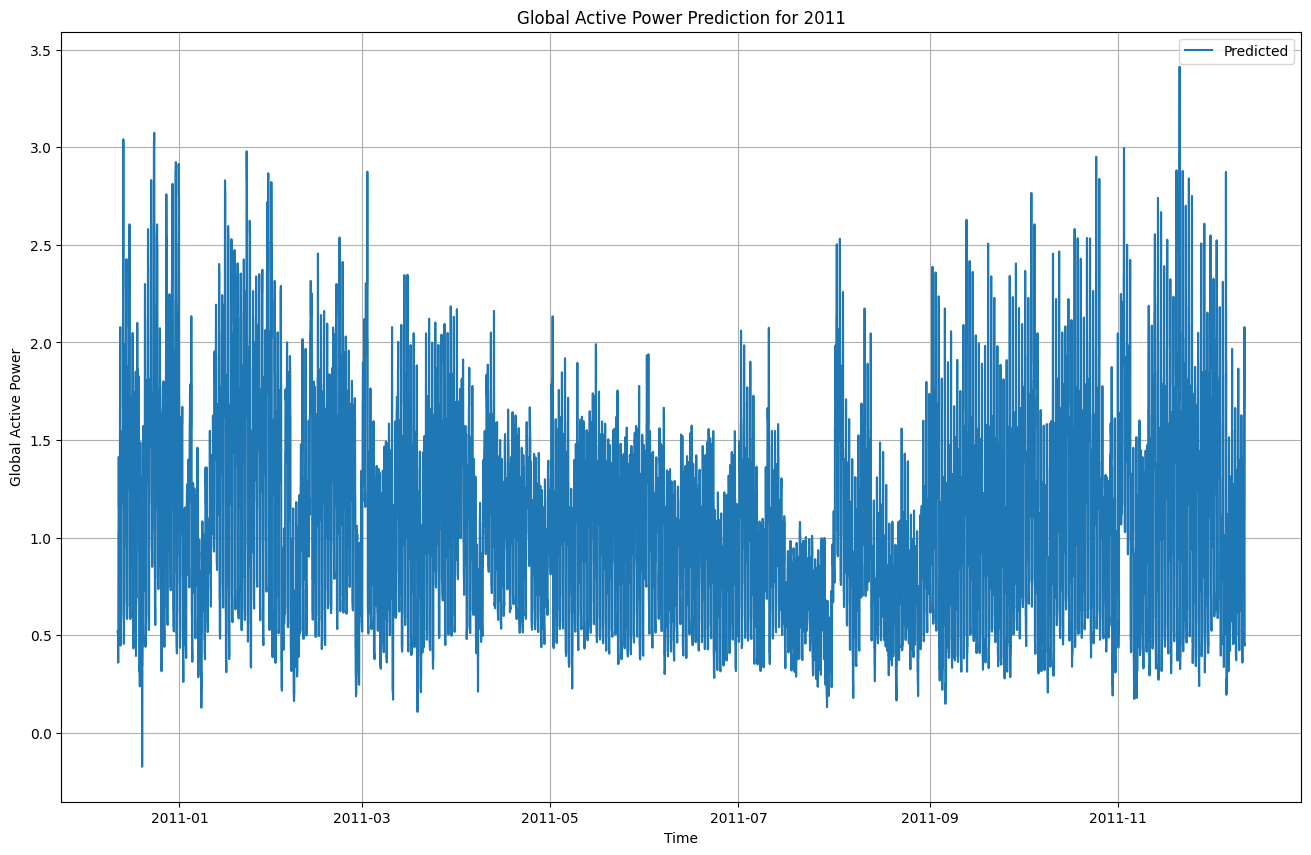

In [ ]:
predicted_power = future_predictions['Global_active_power']

# Filter the data to the desired date range
start_date = '2010-12-12'
end_date = '2011-12-12'
filtered_data = future_data[(future_data['time'] >= start_date) & (future_data['time'] <= end_date)]

# Plot the predicted values for the filtered date range
plt.figure(figsize=(16, 10))  # Adjust figure size as needed
plt.plot(filtered_data['time'], predicted_power[:len(filtered_data)], label='Predicted')
# Use predicted_power values corresponding to the filtered date range

plt.title('Global Active Power Prediction for 2011')
plt.ylabel('Global Active Power')
plt.xlabel('Time')  # Add x-axis label

plt.legend()
plt.grid(True)

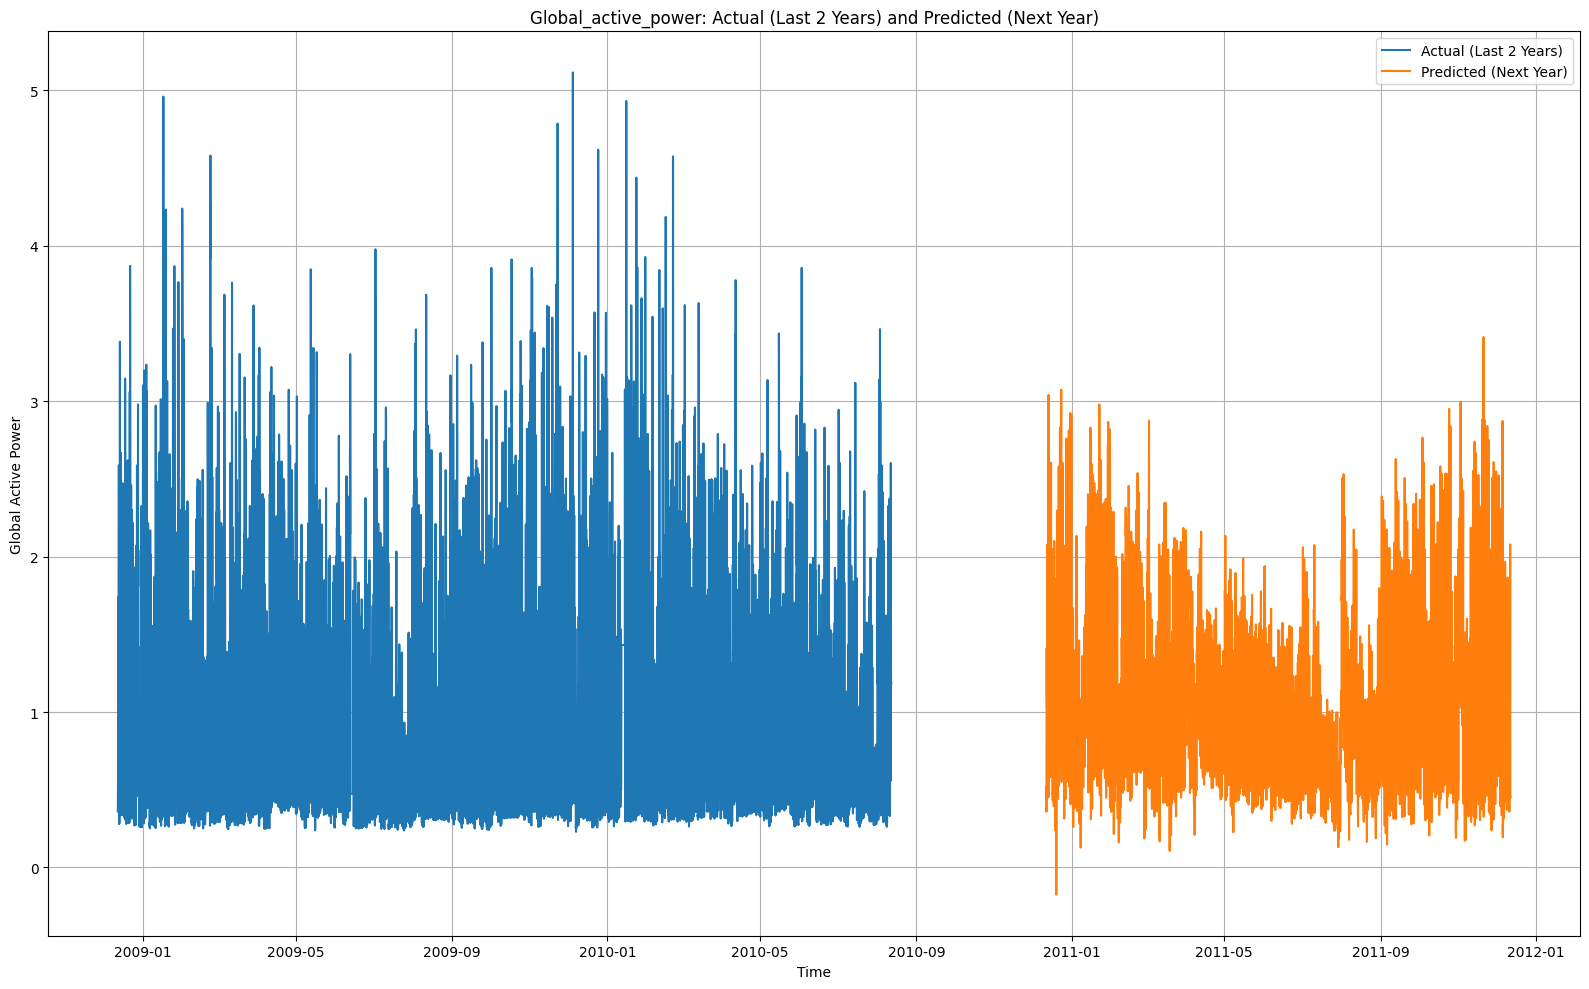

In [ ]:
predicted_power = future_predictions['Global_active_power']

# Filter the original data to the last two years
start_date_actual = '2008-12-12'  # Two years before the prediction start date
end_date_actual = '2010-11-12'  # One day before the prediction start date
filtered_actual_data = df[(df['time'] >= start_date_actual) & (df['time'] <= end_date_actual)]

# Filter the future data to the desired date range
start_date_future = '2010-12-12'
end_date_future = '2011-12-12'
filtered_future_data = future_data[(future_data['time'] >= start_date_future) & (future_data['time'] <= end_date_future)]

# Plot the actual data for the last two years
plt.figure(figsize=(16, 10))
plt.plot(filtered_actual_data['time'], filtered_actual_data['Global_active_power'], label='Actual (Last 2 Years)')

# Plot the predicted data for the next year
plt.plot(filtered_future_data['time'], predicted_power, label='Predicted (Next Year)')

plt.title('Global_active_power: Actual (Last 2 Years) and Predicted (Next Year)')
plt.ylabel('Global Active Power')
plt.xlabel('Time')

plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()